1 - You need to perform a full data analysis and learning with this data, using a traditional machine learning pipeline: data preprocessing, data preparation, training and validation, analysis of results and interpretation. 

The MIMIC-III database (Medical Information Mart for Intensive Care III) contains data collected from patients admitted to intensive care units at the Beth Israel Deaconess Medical Center in Boston, USA, during the period from 2001 to 2012.

More specifically:

Data from the CareVue system covers approximately the years 2001 to 2008.

Data from the MetaVision system spans the years 2008 to 2012.

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score


# Load  MIMIC-III tables
base_path = 'C:/Users/Ines/Desktop/Nova_entrega/Parte_inicial/'
patients = pd.read_csv(f'{base_path}PATIENTS.csv')
admissions = pd.read_csv(f'{base_path}ADMISSIONS.csv')
icustays = pd.read_csv(f'{base_path}ICUSTAYS.csv')

We start by reading the data containing patient information.

-------------------------------------------------------------

In [147]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [148]:
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


We begin by exploring the admissions dataset using some visualizations to better understand its structure and content.

In [149]:
print('Dataset has {} number of unique admission events.'.format(admissions['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(admissions['SUBJECT_ID'].nunique()))
print(admissions['HOSPITAL_EXPIRE_FLAG'].unique()) #Indicates if the patient died during the hospital stay

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.
[0 1]


Here, we observe that several patients have more than one admission. The feature HOSPITAL_EXPIRE_FLAG indicates whether the patient died during the hospital stay, with a value of 1 if the patient died and 0 otherwise.

In [150]:
# Filter only the SUBJECT_IDs that appear more than once
multiple_admissions = admissions[admissions.duplicated('SUBJECT_ID', keep=False)]
num_multiple_admissions = multiple_admissions['SUBJECT_ID'].nunique()
print("Number of patients with multiple admissions:", num_multiple_admissions)

# Function that checks if the values are consistent across the 3 columns
def check_same_values(group):
    return pd.Series({
        'LANGUAGE_same': group['LANGUAGE'].nunique() == 1,
        'RELIGION_same': group['RELIGION'].nunique() == 1,
        'ETHNICITY_same': group['ETHNICITY'].nunique() == 1
    })

# Check consistency
consistency = multiple_admissions.groupby('SUBJECT_ID').apply(check_same_values).reset_index()

# Filter the SUBJECT_IDs with at least one inconsistency
inconsistent_subjects = consistency[
    (consistency['LANGUAGE_same'] == False) |
    (consistency['RELIGION_same'] == False) |
    (consistency['ETHNICITY_same'] == False)
]

print("Number of patients with inconsistencies:", inconsistent_subjects['SUBJECT_ID'].nunique())

# Remove
admissions_cleaned = admissions[~admissions['SUBJECT_ID'].isin(inconsistent_subjects['SUBJECT_ID'])]



Number of patients with multiple admissions: 7537
Number of patients with inconsistencies: 2522


C:\Users\Ines\AppData\Local\Temp\ipykernel_3684\2367519153.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency = multiple_admissions.groupby('SUBJECT_ID').apply(check_same_values).reset_index()


Here, we attempt to identify inconsistencies in the data. We assume that the same patient should not have different values for ethnicity, language, or religion across admissions. However, we do not consider marital status as an inconsistency, since it can reasonably change over a 10-year period. For the other attributes, such variations are considered implausible.

In [151]:
admissions_cleaned = admissions_cleaned.drop(columns=['ROW_ID','ADMISSION_LOCATION','DISCHARGE_LOCATION','LANGUAGE','RELIGION','MARITAL_STATUS',
                                      'EDREGTIME','EDOUTTIME','ADMITTIME'])

We drop some columns that do not contribute meaningful information to our main objective.

In [152]:
print(admissions_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 52552 entries, 0 to 58975
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SUBJECT_ID            52552 non-null  int64 
 1   HADM_ID               52552 non-null  int64 
 2   DISCHTIME             52552 non-null  object
 3   DEATHTIME             5214 non-null   object
 4   ADMISSION_TYPE        52552 non-null  object
 5   INSURANCE             52552 non-null  object
 6   ETHNICITY             52552 non-null  object
 7   DIAGNOSIS             52535 non-null  object
 8   HOSPITAL_EXPIRE_FLAG  52552 non-null  int64 
 9   HAS_CHARTEVENTS_DATA  52552 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 4.4+ MB
None


In [153]:
import pandas as pd

# Replace null values in DEATHTIME with 0
admissions_cleaned['DEATHTIME'] = admissions_cleaned['DEATHTIME'].fillna(0)

# Convert DISCHTIME to datetime.
admissions_cleaned['DISCHTIME'] = pd.to_datetime(admissions_cleaned['DISCHTIME'])

# Convert DEATHTIME to datetime if it is not 0
admissions_cleaned['DEATHTIME'] = admissions_cleaned['DEATHTIME'].apply(
    lambda x: pd.to_datetime(x) if x != 0 else x
)

print(f"Before cleaning: {len(admissions_cleaned)} rows")

rows_to_remove = []
count_removed = 0

# Check for inconsistencies
for idx, row in admissions_cleaned.iterrows():
    deathtime = row['DEATHTIME']
    dischtime = row['DISCHTIME']
    expire_flag = row['HOSPITAL_EXPIRE_FLAG']
    
    if deathtime == 0:
        continue  # The patient did not die
    elif deathtime <= dischtime and expire_flag != 1:
        # Death occurred before discharge, but it is not marked as an in-hospital death
        rows_to_remove.append(idx)
    else:
        count_removed += 1  # Remaining cases

# Remove invalid records
admissions_cleaned = admissions_cleaned.drop(rows_to_remove)

print(f"Number of rows removed: {len(rows_to_remove)}")
print(f"After cleaning: {len(admissions_cleaned)} rows")

Before cleaning: 52552 rows
Number of rows removed: 0
After cleaning: 52552 rows


Just another check to ensure that the dataset is correct and free of inconsistencies.

In [154]:
admissions_cleaned = admissions_cleaned.drop(columns=['DISCHTIME','DEATHTIME'])
admissions_cleaned = admissions_cleaned.reset_index(drop=True)
print(admissions_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52552 entries, 0 to 52551
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SUBJECT_ID            52552 non-null  int64 
 1   HADM_ID               52552 non-null  int64 
 2   ADMISSION_TYPE        52552 non-null  object
 3   INSURANCE             52552 non-null  object
 4   ETHNICITY             52552 non-null  object
 5   DIAGNOSIS             52535 non-null  object
 6   HOSPITAL_EXPIRE_FLAG  52552 non-null  int64 
 7   HAS_CHARTEVENTS_DATA  52552 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 3.2+ MB
None


Here, we notice that the 'DIAGNOSIS' feature still contains some null values. We will investigate this further to prepare the complete admissions dataset for model training.

In [155]:
print(admissions_cleaned['DIAGNOSIS'].value_counts())

DIAGNOSIS
NEWBORN                        7619
PNEUMONIA                      1387
SEPSIS                          979
CORONARY ARTERY DISEASE         784
CONGESTIVE HEART FAILURE        771
                               ... 
CARDIAC CARREST                   1
BRAIN ARTERIAL CLOT               1
EPISTAXIS/SDA                     1
ANASARCA;SLEEP APNEA              1
FEVER;DEHYDRATION;NECK MASS       1
Name: count, Length: 13874, dtype: int64


The DIAGNOSIS column is a nominal categorical variable (there is no logical order between the values), with many distinct entries — some very common (e.g., NEWBORN, PNEUMONIA) and others very rare.

In addition, there appear to be composite values such as FEVER;DEHYDRATION;NECK MASS, which indicates multiple diagnoses in a single record.

In [156]:
from sklearn.preprocessing import LabelEncoder

# Replace nulls with 'UNKNOWN
admissions_cleaned['DIAGNOSIS'] = admissions_cleaned['DIAGNOSIS'].fillna('UNKNOWN')

# Split the diagnoses into lists and remove whitespace
admissions_cleaned['DIAGNOSIS_LIST'] = admissions_cleaned['DIAGNOSIS'].str.split(';').apply(
    lambda lst: [d.strip() for d in lst]
)

#Explode the DataFrame: one row per diagnosis
admissions_exploded = admissions_cleaned.explode('DIAGNOSIS_LIST').reset_index(drop=True)

#Encode the diagnoses using LabelEncoder
le = LabelEncoder()
admissions_exploded['DIAGNOSIS_ID'] = le.fit_transform(admissions_exploded['DIAGNOSIS_LIST'])

#Remove the original text column
admissions_exploded.drop(columns=['DIAGNOSIS', 'DIAGNOSIS_LIST'], inplace=True)

In [157]:
print(admissions_exploded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61281 entries, 0 to 61280
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SUBJECT_ID            61281 non-null  int64 
 1   HADM_ID               61281 non-null  int64 
 2   ADMISSION_TYPE        61281 non-null  object
 3   INSURANCE             61281 non-null  object
 4   ETHNICITY             61281 non-null  object
 5   HOSPITAL_EXPIRE_FLAG  61281 non-null  int64 
 6   HAS_CHARTEVENTS_DATA  61281 non-null  int64 
 7   DIAGNOSIS_ID          61281 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.7+ MB
None


In [158]:
print(admissions_exploded['ADMISSION_TYPE'].value_counts())

ADMISSION_TYPE
EMERGENCY    44419
ELECTIVE      7943
NEWBORN       7628
URGENT        1291
Name: count, dtype: int64


In [159]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
admissions_exploded['ADMISSION_TYPE_ENC'] = le.fit_transform(admissions_exploded['ADMISSION_TYPE'])
admissions_exploded.drop('ADMISSION_TYPE', axis=1, inplace=True)
print(admissions_exploded['ADMISSION_TYPE_ENC'].value_counts())

ADMISSION_TYPE_ENC
1    44419
0     7943
2     7628
3     1291
Name: count, dtype: int64


In [160]:
print(admissions_exploded['INSURANCE'].value_counts())

INSURANCE
Medicare      29788
Private       23080
Medicaid       5856
Government     1894
Self Pay        663
Name: count, dtype: int64


In [161]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
admissions_exploded['INSURANCE_ENC'] = le.fit_transform(admissions_exploded['INSURANCE'])
admissions_exploded.drop('INSURANCE', axis=1, inplace=True)
print(admissions_exploded['INSURANCE_ENC'].value_counts())

INSURANCE_ENC
2    29788
3    23080
1     5856
0     1894
4      663
Name: count, dtype: int64


In [162]:
print(admissions_exploded['ETHNICITY'].value_counts())

ETHNICITY
WHITE                                                       42908
BLACK/AFRICAN AMERICAN                                       5496
UNKNOWN/NOT SPECIFIED                                        4621
HISPANIC OR LATINO                                           1763
ASIAN                                                        1498
OTHER                                                        1419
UNABLE TO OBTAIN                                              951
PATIENT DECLINED TO ANSWER                                    590
ASIAN - CHINESE                                               288
HISPANIC/LATINO - PUERTO RICAN                                249
BLACK/CAPE VERDEAN                                            217
WHITE - RUSSIAN                                               172
MULTI RACE ETHNICITY                                          133
BLACK/HAITIAN                                                 112
WHITE - OTHER EUROPEAN                                         90


In [163]:
def group_ethnicity(ethnicity):
    ethnicity = ethnicity.upper()
    if "ASIAN" in ethnicity:
        return "ASIAN"
    elif "BLACK" in ethnicity or "AFRICAN" in ethnicity:
        return "AFRICAN"
    elif "WHITE" in ethnicity or "EUROPEAN" in ethnicity or "RUSSIAN" in ethnicity:
        return "EUROPEAN"
    elif "HISPANIC" in ethnicity or "LATINO" in ethnicity or "PUERTO RICAN" in ethnicity or "DOMINICAN" in ethnicity or "GUATEMALAN" in ethnicity or "HONDURAN" in ethnicity or "AMERICAN INDIAN" in ethnicity or "ALASKA NATIVE" in ethnicity or "NATIVE"in ethnicity or "BRAZILIAN" in ethnicity or "HAITIAN" in ethnicity or "MIDDLE EASTERN" in ethnicity:
        return "AMERICAN"
    elif "OTHER" in ethnicity:
        return "OTHER"
    elif "UNKNOWN" in ethnicity or "UNABLE" in ethnicity or "DECLINED" in ethnicity:
        return "UNKNOWN"
    else:
        return "OTHER"


Group ethnicities into broader categories, such as continents or larger groups, to simplify the model and avoid having many categories with few samples. This helps reduce dimensionality and improve robustness.

In [164]:
admissions_exploded['ETHNICITY_GROUP'] = admissions_exploded['ETHNICITY'].apply(group_ethnicity)
print(admissions_exploded['ETHNICITY_GROUP'].value_counts())

ETHNICITY_GROUP
EUROPEAN    43253
UNKNOWN      6162
AFRICAN      5866
AMERICAN     2333
ASIAN        2032
OTHER        1635
Name: count, dtype: int64


In [165]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
admissions_exploded['ETHNICITY_GROUP_ENC'] = le.fit_transform(admissions_exploded['ETHNICITY_GROUP'])
admissions_exploded.drop('ETHNICITY_GROUP', axis=1, inplace=True)
admissions_exploded.drop('ETHNICITY', axis=1, inplace=True)
print(admissions_exploded['ETHNICITY_GROUP_ENC'].value_counts())

ETHNICITY_GROUP_ENC
3    43253
5     6162
0     5866
1     2333
2     2032
4     1635
Name: count, dtype: int64


So, we apply label encoding to the features that are not numeric.

In [166]:
non_numeric_cols = admissions_exploded.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", list(non_numeric_cols))

all_numeric = len(non_numeric_cols) == 0
print("All columns numeric?", all_numeric)

Non-numeric columns: []
All columns numeric? True


Now, all the columns are numeric, and in our view, this dataset is ready for training.

In [167]:
unique_subjects = admissions_exploded['SUBJECT_ID'].unique()
print(unique_subjects)

[   22    23    24 ... 98800 98802 98805]


Here, we look at the range of values in the subject ID to later compare it with other datasets containing the same feature.

In [168]:
admissions_exploded.to_excel('admissions_cleaned.xlsx', index=False)

Save this cleaned admissions dataset to an Excel file for further analysis.

------------------------------------------------------------

In [169]:
patients.info()
patients.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [170]:
patients = patients.reset_index(drop=True)
unique_subjects = patients['SUBJECT_ID'].unique()
print(unique_subjects)

[  249   250   251 ... 44123 44126 44128]


Here, we see that there are fewer subjects than in the admissions dataset.

In [171]:
duplicated_subjects = patients['SUBJECT_ID'].duplicated().sum()
print(f"patients_duplicated: {duplicated_subjects}")


patients_duplicated: 0


Here, we do not have duplicated patients, unlike in the admissions dataset.

In [172]:
patients_cleaned = patients.drop(columns=['DOD_HOSP','DOD_SSN', 'ROW_ID'])
patients_cleaned['DOD'] = patients_cleaned['DOD'].fillna(0)
patients_cleaned['DOD'] = patients_cleaned['DOD'].apply(
    lambda x: pd.to_datetime(x) if x != 0 else x
)

print(len(patients_cleaned))

patients_cleaned = patients_cleaned[~(
    (patients_cleaned['DOD']==0) & 
    (patients_cleaned['DOD'] != patients_cleaned['EXPIRE_FLAG'])
)]

print(len(patients_cleaned))

46520
46520


Confirming that expire flag is 1 when the subject was died and 0 when is alive. Also replace the Na values to zero and drop some columns that doesn't are relevant for our objective.

In [173]:
patients_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SUBJECT_ID   46520 non-null  int64 
 1   GENDER       46520 non-null  object
 2   DOB          46520 non-null  object
 3   DOD          46520 non-null  object
 4   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


Also in the MIMIC-III database, patients older than 89 years at any time during their hospital stay have their dates of birth (DOB) artificially altered as an anonymization measure in accordance with HIPAA (Health Insurance Portability and Accountability Act) regulations. The entire dataset has been chronologically shifted for anonymization purposes (e.g., all dates may be shifted by decades), so these years appear as 2089, 2164, etc.

That said, we decided to remove the patients' ages, as we considered that the complexity involved in obtaining accurate ages outweighed the potential statistical benefit.

In [174]:
patients_cleaned = patients_cleaned.drop(columns=['DOB','DOD'])

In [175]:
print(patients_cleaned['GENDER'].value_counts())

patients_cleaned['GENDER_ENCODED'] = patients_cleaned['GENDER'].map({'F': 1, 'M': 0})

patients_cleaned.drop(columns=['GENDER'], inplace=True)

GENDER
M    26121
F    20399
Name: count, dtype: int64


In [176]:
patients_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   SUBJECT_ID      46520 non-null  int64
 1   EXPIRE_FLAG     46520 non-null  int64
 2   GENDER_ENCODED  46520 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


In [177]:
patients_cleaned.to_excel('patients_cleaned.xlsx', index=False)

------------------------------------------------------------

In [178]:
print(icustays.info())
unique_subjects = icustays['SUBJECT_ID'].unique()
print(unique_subjects)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB
None
[  268   269   270 ... 94953 94954 94956]


Here, we have more subjects than in the patients dataset but fewer than in the admissions dataset.

In [179]:
print(icustays.head())

   ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  \
0          MICU            52           52  2198-02-14 23:27:38   
1          MICU            52           52  2170-11-05 11:05:29   
2           CCU            57           57  2128-06-24 15:05:20   
3          SICU            52           23  2120-08-07 23:12:42   
4           CCU            57           57  2186-12-25 21:08:04   

               OUTTIME     LOS  
0  2198-02-18 05:26:11  3.2490  
1  2170-11-08 17:46:57  3.2788  
2  2128-06-27 12:32:29  2.8939  
3  2120-08-10 00:39:04  2.0600  
4  2186-12-

In [180]:
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
icustays['LOSC'] = (icustays['OUTTIME'] - icustays['INTIME']).dt.total_seconds() / 3600
icustays['LOSC_in_days'] = icustays['LOSC'] / 24
diff=icustays['LOS_diff_days'] = (icustays['LOS'] - icustays['LOSC_in_days']).abs()
print(diff)
print(icustays[['LOS', 'LOSC_in_days']].describe())

0        6.944444e-06
1        3.703704e-06
2        4.583333e-05
3        2.314815e-05
4        4.305556e-05
             ...     
61527    1.851852e-06
61528    3.611111e-05
61529    4.907407e-05
61530    4.120370e-05
61531    9.259259e-07
Length: 61532, dtype: float64
                LOS  LOSC_in_days
count  61522.000000  61522.000000
mean       4.917972      4.917971
std        9.638784      9.638784
min        0.000100      0.000139
25%        1.108025      1.108070
50%        2.092250      2.092234
75%        4.483175      4.483157
max      173.072500    173.072512


Just to confirm that the intime and outtime values correspond to the Length of Stay (LOS) provided in this dataset.

In [181]:
icustays_cleaned = icustays.dropna(subset=['LOS'])

Selecting only the rows with values in LOS, since that is our objective.

In [182]:
icustays_cleaned = icustays_cleaned.drop(columns=['LOS_diff_days','OUTTIME','FIRST_WARDID','LAST_WARDID','LOSC_in_days','LOSC','ROW_ID', 'INTIME'])
print(icustays_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 61522 entries, 0 to 61531
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SUBJECT_ID      61522 non-null  int64  
 1   HADM_ID         61522 non-null  int64  
 2   ICUSTAY_ID      61522 non-null  int64  
 3   DBSOURCE        61522 non-null  object 
 4   FIRST_CAREUNIT  61522 non-null  object 
 5   LAST_CAREUNIT   61522 non-null  object 
 6   LOS             61522 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 3.8+ MB
None


In [183]:
print(icustays_cleaned['DBSOURCE'].value_counts())

DBSOURCE
carevue       37766
metavision    23620
both            136
Name: count, dtype: int64


In [184]:
dbsource_dummies = pd.get_dummies(icustays_cleaned['DBSOURCE'], prefix='DBSOURCE').astype(int)
icustays_cleaned = pd.concat([icustays_cleaned, dbsource_dummies], axis=1)
icustays_cleaned.drop(columns=['DBSOURCE'], inplace=True)

In [185]:
print(icustays_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 61522 entries, 0 to 61531
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SUBJECT_ID           61522 non-null  int64  
 1   HADM_ID              61522 non-null  int64  
 2   ICUSTAY_ID           61522 non-null  int64  
 3   FIRST_CAREUNIT       61522 non-null  object 
 4   LAST_CAREUNIT        61522 non-null  object 
 5   LOS                  61522 non-null  float64
 6   DBSOURCE_both        61522 non-null  int64  
 7   DBSOURCE_carevue     61522 non-null  int64  
 8   DBSOURCE_metavision  61522 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.7+ MB
None


In [186]:
print(icustays_cleaned['FIRST_CAREUNIT'].value_counts())

FIRST_CAREUNIT
MICU     21086
CSRU      9311
SICU      8891
NICU      8093
CCU       7726
TSICU     6415
Name: count, dtype: int64


In [187]:
print(icustays_cleaned['LAST_CAREUNIT'].value_counts())

LAST_CAREUNIT
MICU     21308
CSRU      9391
SICU      9213
NICU      8093
CCU       7406
TSICU     6111
Name: count, dtype: int64


In [188]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

first = icustays_cleaned['FIRST_CAREUNIT']
last = icustays_cleaned['LAST_CAREUNIT']

all_categories = pd.concat([first, last]).unique()

le = LabelEncoder()
le.fit(all_categories)

icustays_cleaned['FIRST_CAREUNIT_ENC'] = le.transform(first)
icustays_cleaned['LAST_CAREUNIT_ENC'] = le.transform(last)

icustays_cleaned = icustays_cleaned.drop(columns=['FIRST_CAREUNIT','LAST_CAREUNIT'])

In [189]:
print(icustays_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 61522 entries, 0 to 61531
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SUBJECT_ID           61522 non-null  int64  
 1   HADM_ID              61522 non-null  int64  
 2   ICUSTAY_ID           61522 non-null  int64  
 3   LOS                  61522 non-null  float64
 4   DBSOURCE_both        61522 non-null  int64  
 5   DBSOURCE_carevue     61522 non-null  int64  
 6   DBSOURCE_metavision  61522 non-null  int64  
 7   FIRST_CAREUNIT_ENC   61522 non-null  int64  
 8   LAST_CAREUNIT_ENC    61522 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 4.7 MB
None


In [190]:
icustays_cleaned.to_excel('icustays_cleaned.xlsx', index=False)

-------------------------------------------------------------

In [191]:
diagnoses_icd = pd.read_csv(f'{base_path}DIAGNOSES_ICD.csv')
d_icd_diagnoses = pd.read_csv(f'{base_path}D_ICD_DIAGNOSES.csv')

Reading these two additional datasets for overall analysis.

In [192]:
print(diagnoses_icd.head())
print(diagnoses_icd.info())
print(d_icd_diagnoses.head())
print(d_icd_diagnoses.info())

   ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0    1297         109   172335      1.0     40301
1    1298         109   172335      2.0       486
2    1299         109   172335      3.0     58281
3    1300         109   172335      4.0      5855
4    1301         109   172335      5.0      4254
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB
None
   ROW_ID ICD9_CODE               SHORT_TITLE  \
0     174     01166     TB pneumonia-oth test   
1     175     01170    TB pneumothorax-unspec   
2     176     01171   TB pneumothorax-no exam   
3     177     01172  TB pneumoth

In [193]:
diagnoses_icd_cleaned = diagnoses_icd.dropna(subset=['ICD9_CODE']).copy()

In [194]:
short_long_counts = d_icd_diagnoses.groupby('SHORT_TITLE')['LONG_TITLE'].nunique()

short_multiple_long = short_long_counts[short_long_counts > 1]

print(short_multiple_long)


SHORT_TITLE
Anesth compl-postpartum     2
Child abuse NOS             2
Cl skl base fx-deep coma    5
Cl skl base fx-prol coma    5
Cl skl fx NEC-proln coma    5
                           ..
Opn skul/oth fx-coma NOS    5
Opn skul/oth fx-mod coma    5
Opn skull fx NEC-concuss    5
Opn skull/oth fx-concuss    5
Osteoarthrosis-mult site    2
Name: LONG_TITLE, Length: 74, dtype: int64


In the d_icd_diagnoses dataset, we see that the feature 'short title' encompasses multiple types of 'long title'. Therefore, we will use the 'long title' since it contains more detailed information.

In [195]:
d_icd_diagnoses_cleaned = d_icd_diagnoses.drop(columns=['SHORT_TITLE', 'ROW_ID'])
print(d_icd_diagnoses_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14567 entries, 0 to 14566
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ICD9_CODE   14567 non-null  object
 1   LONG_TITLE  14567 non-null  object
dtypes: object(2)
memory usage: 227.7+ KB
None


In [196]:
d_icd_diagnoses_cleaned.to_excel('d_icd_diagnoses_cleaned.xlsx', index=False)

In [197]:
def classify_icd9_code(icd_code):
    try:
        icd_code = str(icd_code).strip()

        if icd_code.startswith(('E', 'V')):
            return 'External causes of injury and supplemental classification'

        code3 = icd_code.lstrip('0')[:3]
        if not code3.isdigit():
            return 'Unknown'

        code = int(code3)

        if 1 <= code <= 139:
            return 'Infectious diseases'
        elif 140 <= code <= 239:
            return 'Neoplasms'
        elif 240 <= code <= 279:
            return 'Endocrine/metabolic'
        elif 280 <= code <= 289:
            return 'Blood diseases'
        elif 290 <= code <= 319:
            return 'Mental disorders'
        elif 320 <= code <= 389:
            return 'Nervous system'
        elif 390 <= code <= 459:
            return 'Circulatory system'
        elif 460 <= code <= 519:
            return 'Respiratory system'
        elif 520 <= code <= 579:
            return 'Digestive system'
        elif 580 <= code <= 629:
            return 'Genitourinary system'
        elif 630 <= code <= 679:
            return 'Pregnancy/childbirth'
        elif 680 <= code <= 709:
            return 'Skin diseases'
        elif 710 <= code <= 739:
            return 'Musculoskeletal'
        elif 740 <= code <= 759:
            return 'Congenital anomalies'
        elif 760 <= code <= 779:
            return 'Perinatal conditions'
        elif 780 <= code <= 799:
            return 'Symptoms/ill-defined'
        elif 800 <= code <= 999:
            return 'Injury/poisoning'
        elif code > 999:
            return 'Null/Invalid code'
    except:
        pass
    return 'Unknown'

diagnoses_icd_cleaned['ICD9_CATEGORY'] = diagnoses_icd_cleaned['ICD9_CODE'].apply(classify_icd9_code)

# Map to numeric recode
category_to_recode = {
    'Infectious diseases': 0,
    'Neoplasms': 1,
    'Endocrine/metabolic': 2,
    'Blood diseases': 3,
    'Mental disorders': 4,
    'Nervous system': 5,
    'Circulatory system': 6,
    'Respiratory system': 7,
    'Digestive system': 8,
    'Genitourinary system': 9,
    'Pregnancy/childbirth': 10,
    'Skin diseases': 11,
    'Musculoskeletal': 12,
    'Congenital anomalies': 13,
    'Perinatal conditions': 14,
    'Symptoms/ill-defined': 15,
    'Injury/poisoning': 16,
    'External causes of injury and supplemental classification': 17,
    'Unknown': 18
}

diagnoses_icd_cleaned['recode'] = diagnoses_icd_cleaned['ICD9_CATEGORY'].map(category_to_recode)

diagnoses_icd_cleaned = diagnoses_icd_cleaned.drop(columns=['ROW_ID'])
diagnoses_icd_cleaned = diagnoses_icd_cleaned.reset_index(drop=True)
print(diagnoses_icd_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651000 entries, 0 to 650999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   SUBJECT_ID     651000 non-null  int64  
 1   HADM_ID        651000 non-null  int64  
 2   SEQ_NUM        651000 non-null  float64
 3   ICD9_CODE      651000 non-null  object 
 4   ICD9_CATEGORY  651000 non-null  object 
 5   recode         651000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 29.8+ MB
None


In [198]:
diagnoses_icd_cleaned = diagnoses_icd_cleaned.drop(columns=['ICD9_CATEGORY'])

In [199]:
diagnoses_icd_cleaned.to_excel('diagnoses_icd_cleaned.xlsx', index=False)

------------------------------------------------------------

Combine all datasets to begin preparing a unified dataset for model training.

In [200]:
merged_df = diagnoses_icd_cleaned.copy()

merged_df = merged_df.merge(d_icd_diagnoses_cleaned, on='ICD9_CODE', how='inner')
merged_df = merged_df.merge(patients_cleaned, on='SUBJECT_ID', how='inner')
merged_df = merged_df.merge(admissions_exploded, on='HADM_ID', how='inner')

cols_to_merge = [col for col in icustays_cleaned.columns if col not in merged_df.columns]
if 'HADM_ID' not in cols_to_merge:
    cols_to_merge.append('HADM_ID')

merged_df = merged_df.merge(icustays_cleaned[cols_to_merge], on='HADM_ID', how='inner')

print(merged_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738410 entries, 0 to 738409
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SUBJECT_ID_x          738410 non-null  int64  
 1   HADM_ID               738410 non-null  int64  
 2   SEQ_NUM               738410 non-null  float64
 3   ICD9_CODE             738410 non-null  object 
 4   recode                738410 non-null  int64  
 5   LONG_TITLE            738410 non-null  object 
 6   EXPIRE_FLAG           738410 non-null  int64  
 7   GENDER_ENCODED        738410 non-null  int64  
 8   SUBJECT_ID_y          738410 non-null  int64  
 9   HOSPITAL_EXPIRE_FLAG  738410 non-null  int64  
 10  HAS_CHARTEVENTS_DATA  738410 non-null  int64  
 11  DIAGNOSIS_ID          738410 non-null  int64  
 12  ADMISSION_TYPE_ENC    738410 non-null  int64  
 13  INSURANCE_ENC         738410 non-null  int64  
 14  ETHNICITY_GROUP_ENC   738410 non-null  int64  
 15  

In [201]:
cols_to_drop = [col for col in merged_df.columns if col.startswith('SUBJECT_ID_')]
merged_df.drop(columns=cols_to_drop, inplace=True)

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738410 entries, 0 to 738409
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HADM_ID               738410 non-null  int64  
 1   SEQ_NUM               738410 non-null  float64
 2   ICD9_CODE             738410 non-null  object 
 3   recode                738410 non-null  int64  
 4   LONG_TITLE            738410 non-null  object 
 5   EXPIRE_FLAG           738410 non-null  int64  
 6   GENDER_ENCODED        738410 non-null  int64  
 7   HOSPITAL_EXPIRE_FLAG  738410 non-null  int64  
 8   HAS_CHARTEVENTS_DATA  738410 non-null  int64  
 9   DIAGNOSIS_ID          738410 non-null  int64  
 10  ADMISSION_TYPE_ENC    738410 non-null  int64  
 11  INSURANCE_ENC         738410 non-null  int64  
 12  ETHNICITY_GROUP_ENC   738410 non-null  int64  
 13  SUBJECT_ID            738410 non-null  int64  
 14  ICUSTAY_ID            738410 non-null  int64  
 15  

In [202]:
merged_df = merged_df.drop(columns=['ICD9_CODE','LONG_TITLE','HADM_ID', 'HAS_CHARTEVENTS_DATA', 'DIAGNOSIS_ID', 'SUBJECT_ID','ICUSTAY_ID'])

We need to remove the identifying features, as well as those that are meaningless or redundant.

In [203]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738410 entries, 0 to 738409
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SEQ_NUM               738410 non-null  float64
 1   recode                738410 non-null  int64  
 2   EXPIRE_FLAG           738410 non-null  int64  
 3   GENDER_ENCODED        738410 non-null  int64  
 4   HOSPITAL_EXPIRE_FLAG  738410 non-null  int64  
 5   ADMISSION_TYPE_ENC    738410 non-null  int64  
 6   INSURANCE_ENC         738410 non-null  int64  
 7   ETHNICITY_GROUP_ENC   738410 non-null  int64  
 8   LOS                   738410 non-null  float64
 9   DBSOURCE_both         738410 non-null  int64  
 10  DBSOURCE_carevue      738410 non-null  int64  
 11  DBSOURCE_metavision   738410 non-null  int64  
 12  FIRST_CAREUNIT_ENC    738410 non-null  int64  
 13  LAST_CAREUNIT_ENC     738410 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 78.9 MB
None


This concludes the data preprocessing step.

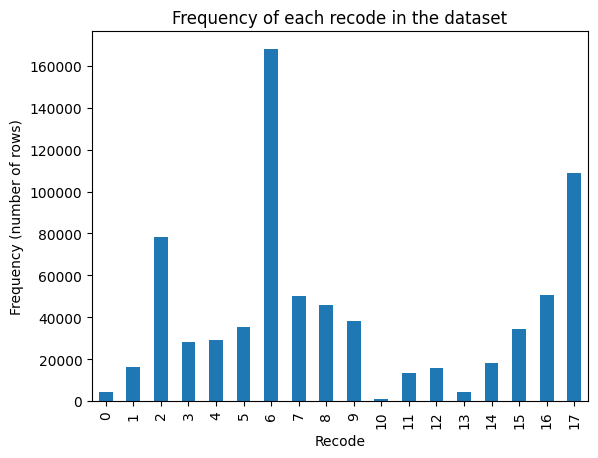

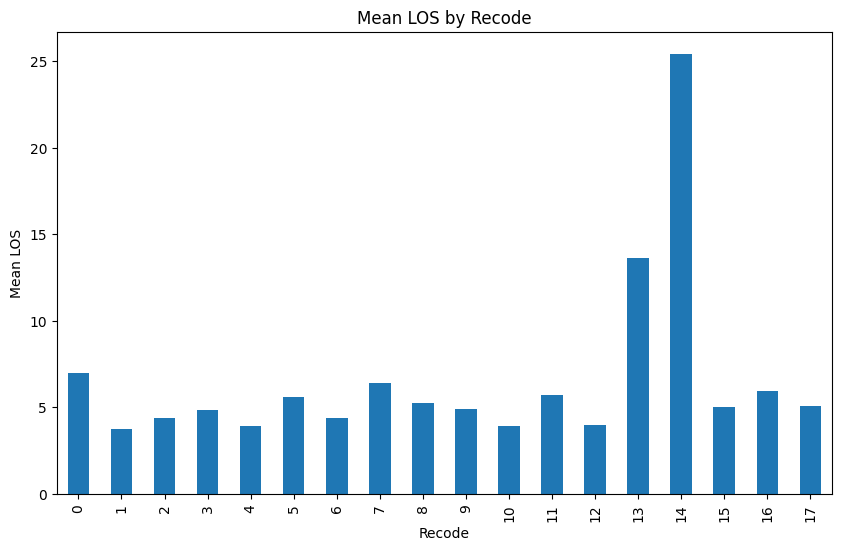

In [204]:
recode_counts = merged_df['recode'].value_counts().sort_index()

recode_counts.plot(kind='bar')
plt.xlabel('Recode')
plt.ylabel('Frequency (number of rows)')
plt.title('Frequency of each recode in the dataset')
plt.show()

mean_los_per_recode = merged_df.groupby('recode')['LOS'].mean().sort_index()

mean_los_per_recode.plot(kind='bar', figsize=(10,6))
plt.xlabel('Recode')
plt.ylabel('Mean LOS')
plt.title('Mean LOS by Recode')
plt.show()


Here, we conclude that health problems related to the circulatory system are the most frequent. Additionally, we observe that perinatal conditions (recoded as category 14) are associated with the longest ICU stays.

c:\Users\Ines\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=20 is greater than n_features=13. All the features will be returned.
  warnings.warn(


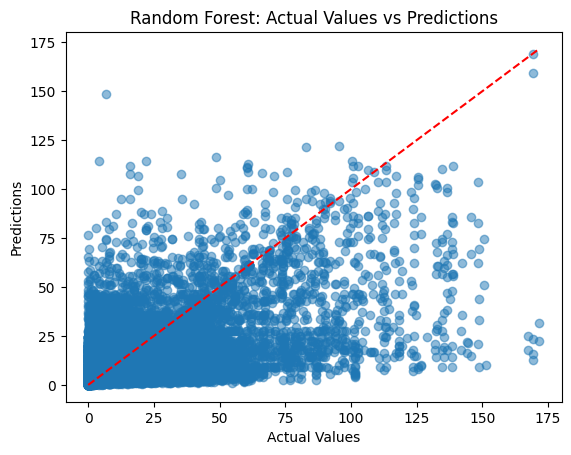

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Features e target
X = merged_df.drop(columns=['LOS']) 
y = merged_df['LOS']

# Feature selection
selector = SelectKBest(score_func=f_regression, k=20) 
X_selected = selector.fit_transform(X, y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Random Forest: Actual Values vs Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Random Forest Regressor is an ensemble tree-based method. It builds many decision trees and averages their predictions. It can model complex, nonlinear relationships.

In [206]:
mean_target = merged_df['LOS'].mean()

print(f"Target mean: {mean_target:.2f}")

Target mean: 5.49


The scatter plot shows the performance of a Random Forest model by comparing actual values (x-axis) to predicted values (y-axis). Ideally, if the model had perfect accuracy, the points would lie along the red dashed diagonal line (which represents perfect agreement between actual and predicted values).

However, in this case, we can see that most of the predictions are concentrated in the lower prediction range, regardless of the actual values. This suggests that the model is underestimating higher actual values — it tends to predict lower values even when the true values are high. The predictions appear biased towards lower values and lack variance, indicating that the model may be overfitting or failing to generalize well for higher target values.

In [207]:
# After fitting the selector
mask = selector.get_support()  # Boolean mask of selected features
selected_features = X.columns[mask]  # Apply mask to original column names

print(selected_features)


Index(['SEQ_NUM', 'recode', 'EXPIRE_FLAG', 'GENDER_ENCODED',
       'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE_ENC', 'INSURANCE_ENC',
       'ETHNICITY_GROUP_ENC', 'DBSOURCE_both', 'DBSOURCE_carevue',
       'DBSOURCE_metavision', 'FIRST_CAREUNIT_ENC', 'LAST_CAREUNIT_ENC'],
      dtype='object')


In [208]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 4.03
MSE: 65.07
R²: 0.34


- **MAE = 4.03**
- **Target variable mean = 5.49**

This means that, on average, the absolute error is about **73% of the target mean**:

This is relatively high — the model is making errors that are almost as large as the typical value of the target. This indicates low prediction accuracy.

- **R² = 0.34**

The model explains only **34% of the variance** in the data. For comparison, a model that always predicts the mean (5.49) would have an R² close to zero. So, your model is **doing better than a constant prediction**, but still **far from ideal**.

---

**Conclusion:** The model shows limited performance. While it's not completely inaccurate, it **fails to capture much of the variability** in the target variable, especially for higher values.


c:\Users\Ines\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=20 is greater than n_features=13. All the features will be returned.
  warnings.warn(


MSE: 91.7763
R²: 0.0658


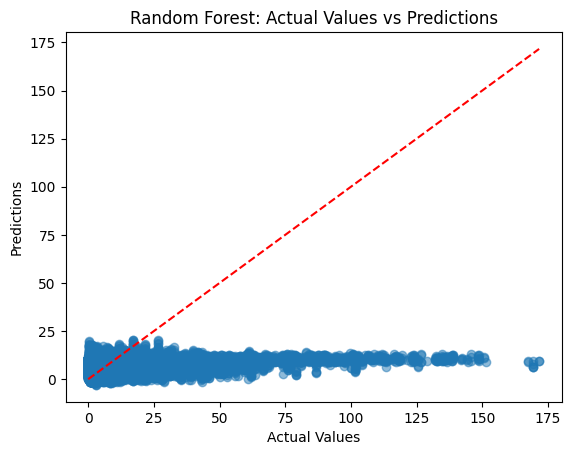

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score

# Features and target
X = merged_df.drop(columns=['LOS'])
y = merged_df['LOS']

# Feature selection (select top 20 features)
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize and train linear regression model
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# Predict on test set
y_pred = model_linear.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Random Forest: Actual Values vs Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


Linear regression fits a straight line (or hyperplane) to data by assuming a linear relationship between features and the target.

In [210]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

#Treinamento e Validação com Cross-Validation e GridSearch
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


Fitting 3 folds for each of 2 candidates, totalling 6 fits


We're performing a grid search with cross-validation to find the best hyperparameters for a Random Forest model based on the lowest mean absolute error.

In [211]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 4.03
MSE: 65.07
R²: 0.34


Since the results are the same, we will proceed with using only the model.

In [212]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=selected_features,
    mode='regression'
)

exp = explainer.explain_instance(X_test[0], model.predict)

exp.show_in_notebook()

print(exp.as_list())

[('ADMISSION_TYPE_ENC <= 1.00', -16.506874770699802), ('1.00 < LAST_CAREUNIT_ENC <= 2.00', -5.029100817263436), ('0.00 < DBSOURCE_metavision <= 1.00', -3.4044169676036034), ('3.00 < SEQ_NUM <= 7.00', -2.9861969991167854), ('EXPIRE_FLAG <= 0.00', -1.9909291267170672), ('1.00 < FIRST_CAREUNIT_ENC <= 2.00', -1.5732432884947816), ('DBSOURCE_both <= 0.00', -1.2890121730679975), ('ETHNICITY_GROUP_ENC <= 3.00', -1.1203875417029525), ('HOSPITAL_EXPIRE_FLAG <= 0.00', 1.071462671401049), ('2.00 < INSURANCE_ENC <= 3.00', 0.9813811745468762)]


The model predicted a **length of stay (LOS)** of approximately **3.13 days** for the selected patient.  
This value is closer to the **minimum LOS (0.40 days)** than the **maximum (157.20 days)**, indicating that the model expects a relatively short hospital stay.

- The **strongest negative influence** on the LOS prediction was the **admission type**.
- Other strong negative contributors included **care unit encodings** and the **data source** used for the patient.
- **Insurance type** and **hospital flags** had **minor positive effects** on the prediction.
- The model estimates that the patient will stay for just over **3 days**, a relatively **short duration** given the possible range.


ADMISSION_TYPE_ENC      0.266847
SEQ_NUM                 0.247802
recode                  0.159589
ETHNICITY_GROUP_ENC     0.073846
INSURANCE_ENC           0.060069
LAST_CAREUNIT_ENC       0.050694
FIRST_CAREUNIT_ENC      0.046958
GENDER_ENCODED          0.042364
EXPIRE_FLAG             0.020399
HOSPITAL_EXPIRE_FLAG    0.017138
dtype: float64


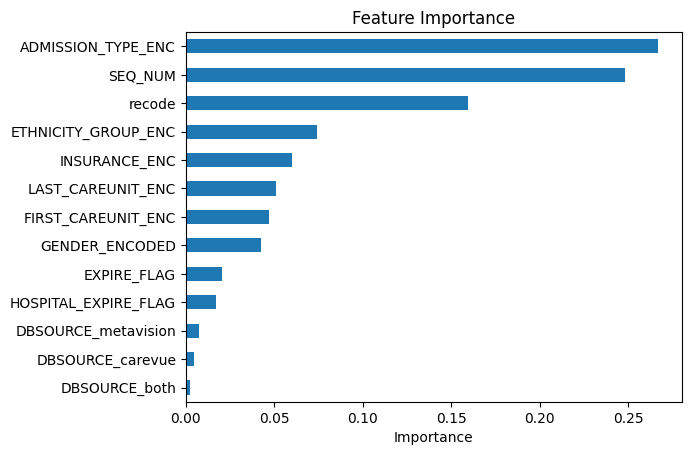

In [213]:
#Feature Importance
importances = model.feature_importances_
features = X.columns

feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print(feat_importance.head(10))

feat_importance.plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()



The bar chart above shows the **global feature importances** derived from the trained Random Forest model. These values represent how much each feature contributes to reducing error across all predictions.

- **`ETHNICITY_GROUP_ENC`** and **`INSURANCE_ENC`**: Moderate importance, suggesting demographic and coverage types affect predicted LOS.
- **`LAST_CAREUNIT_ENC`**, **`FIRST_CAREUNIT_ENC`**, and **`GENDER_ENCODED`**: Show noticeable contributions, indicating care transitions and gender play non-negligible roles.
- **Mortality Flags (`EXPIRE_FLAG`, `HOSPITAL_EXPIRE_FLAG`)**: Have a small but present effect, potentially reflecting end-of-life care differences.
- **`DBSOURCE_*`** features (metavision, carevue, both): Very low importance in this model setup.

------

- The model is most influenced by **admission context** and **visit sequencing**.
- **Demographic and administrative features** carry mid-level influence.
- **Technical data source encodings** have minimal direct effect on predicting LOS.

In [214]:
#GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)

y_pred_gbr = gbr_model.predict(X_test)

# Avaliação
mse = mean_squared_error(y_test, y_pred_gbr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_gbr)
r2 = r2_score(y_test, y_pred_gbr)

print("GradientBoostingRegressor:")
print(f"  MSE: {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R²: {r2:.4f}")


GradientBoostingRegressor:
  MSE: 69.1445
  RMSE: 8.3153
  MAE: 4.3114
  R²: 0.2962


Gradient Boosting builds trees sequentially, with each tree trying to correct the errors of the previous one. It often performs better than Random Forest for many problems, but in this case, it performs worse.

- The model provides **moderate predictive power**, explaining nearly **30%** of the variability in LOS.
- The **RMSE of 8.31** and **MAE of 4.31** suggest predictions are off by several days on average, indicating there’s still room for improvement.

In [215]:
#XGBoost (XGBRegressor)
from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost:")
print(f"  MSE: {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R²: {r2:.4f}")


XGBoost:
  MSE: 62.6865
  RMSE: 7.9175
  MAE: 4.0912
  R²: 0.3619


### `objective='reg:squarederror'` in XGBRegressor

This parameter defines the **loss function** that the XGBoost model optimizes during training.

- The `reg:squarederror` objective corresponds to the **Mean Squared Error (MSE)** loss.
- It measures the average of the squared differences between the predicted values ($\hat{y}$) and the true target values ($y$):

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

- The model aims to minimize this value, which penalizes larger errors more heavily than smaller ones.
- This objective is commonly used for regression problems where predicting continuous values accurately is the goal.


The XGBoost model shows a Mean Squared Error (MSE) of 62.69 and a Root Mean Squared Error (RMSE) of 7.92, indicating the average magnitude of prediction errors. The Mean Absolute Error (MAE) of 4.09 suggests that predictions deviate from actual values by about 4 units on average.

An R² score of 0.36 implies that the model explains roughly 36% of the variance in the target variable, indicating moderate predictive power but leaving room for improvement. However, it was the best-performing model among those tested.